In [1]:
from ipytables import *

In [2]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 10, 5


In [3]:
import itertools
import os.path
import csv
import numpy as np
import scipy.spatial
import pandas as pd
pd.options.display.max_rows=20
pd.options.display.max_seq_items = 100
pd.options.display.max_colwidth = 100

In [4]:
os.chdir("prepared_corpora/opinosis/")

In [5]:
def load_pf_group_index():
    df = pd.read_csv("./phrase_groups.csv")
    df.set_index(["paraphrase_group_index", "phrase_index"], inplace=True)
    return df
    

In [6]:
df = load_pf_group_index()
df["tokenized_phrases"]=[line.strip() for line in open("tokenized_phrases.txt","r")]


In [7]:
df["pvdm"]=list(np.loadtxt("outVectors_wiki_sentence_concat_pvdm.csv", delimiter=","))
df["dbow"]=list(np.loadtxt("outVectors_wiki_sentence_dbow.csv", delimiter=","))
df["urae"]=list(np.loadtxt("outVectors_RAE2011.csv", delimiter=","))
df["mowe"]=list(np.loadtxt("outVectors_mowe.csv", delimiter=","))
df["howe"]=list(np.loadtxt("outVectors_howe.csv", delimiter=","))
df["bow"]=list(np.loadtxt("outVectors_bow.csv", delimiter=","))


In [45]:
from sklearn.decomposition import PCA
df["pca_bow"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(list(df.bow))))
df["pca_howe"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(list(df.howe))))

In [15]:
#Just consider paraphrase groups of a certain size
#df = df.groupby(level=0).filter(lambda group: len(group)>4)

In [16]:

#for base in "pvdm dbow urae".split():
#    df[base+"_bow"] = df[base].combine(df.bow, func=lambda a,b: np.concatenate((a,b)))
#    df["pca_"+base+"_bow"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(df[base+"_bow"])))


In [18]:
from sklearn.manifold import t_sne
def plot_tsne(column):
    tsne = t_sne.TSNE()
    Ys = tsne.fit_transform(np.row_stack(df[column]))
    
    pl.scatter(Ys[:,0],Ys[:,1], c=colors)
    pl.title = column
    
    

#Wei's method

0. Normalise all embeddings for each model
1. within each paraphrase group, for each model, work out average pair-wise cosine similarity (or distance)
  1. the ground truth in this case should be horizontal x axis, which means the best values that each model gets should be close to zero (if you use similarity, rather than distance). So the model with an overall trend of low similarity values capture the semantics better.
2. treat each model's average similarity/distance for the paraphrase groups as a time series, do a z-normalisation () the time (horizontal) axis is the paraphrase group index, and the y axis is the similarity value after the z-normalisation
3. measure the similarity between the four model time series, pair-wise using Euclidean distance to see which model agrees with each other. 


In [46]:
import scipy.spatial.distance as distance

def angular_dist(a,b):
    cos_sim = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return 1- np.arccos(cos_sim)/np.pi


In [47]:
def get_std(series):
    xs=np.row_stack(series)
    std_dev = xs.std(axis=0)
    std_dev[std_dev==0.0]=1.0
    return list(std_dev)
def get_mean(series):
    xs = np.row_stack(series)
    return list(xs.mean(axis=0))

dfs = (df.iloc[:,1:]-df.iloc[:,1:].apply(get_mean))/df.iloc[:,1:].apply(get_std)



In [48]:
np.row_stack( dfs.howe.loc[130]).sum()


-11889.387642390826

In [49]:
group_sims.howe[group_sims.howe.isnull()]

paraphrase_group_index
24    NaN
130   NaN
Name: howe, dtype: float64

,pvdm,dbow,urae,mowe,howe,bow,pca_bow,pca_howe
count,163.000000,163.000000,163.000000,163.000000,161.000000,163.000000,163.000000,161.000000
mean,0.587791,0.576253,0.548110,0.685002,0.649046,0.564433,0.571260,0.560037
std,0.121994,0.056714,0.098365,0.067131,0.088982,0.065802,0.086137,0.068292
min,0.227808,0.421289,0.379853,0.531289,0.432640,0.497569,0.477260,0.489103
25%,0.510333,0.539696,0.491540,0.639814,0.586842,0.518731,0.511911,0.515282
50%,0.590835,0.574679,0.524284,0.680740,0.639509,0.543197,0.543580,0.534538
75%,0.664307,0.610007,0.566776,0.722901,0.704621,0.584322,0.595412,0.580697
max,0.884048,0.791796,0.907306,0.909853,0.915776,0.822428,0.928154,0.818714


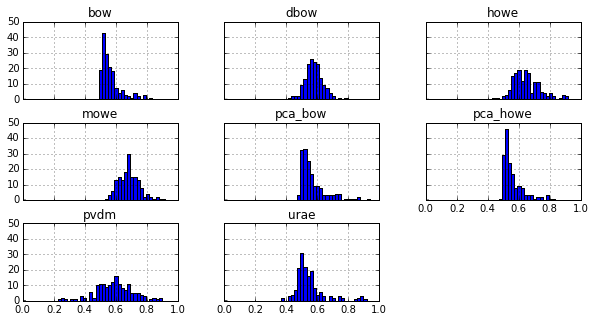

In [50]:
def get_group_sim(group):
    xs = np.row_stack(group)
    #cosine_sim = (1-distance.pdist(xs, 'cosine'))
    dist = distance.pdist(xs,angular_dist)
    return dist.mean()

group_sims = dfs.groupby(level=0).agg(get_group_sim)
group_sims.hist(bins=np.linspace(0,1,50), sharex=True, sharey=True)
group_sims.describe()

               pvdm       dbow       urae       mowe  howe        bow  \
pvdm       0.000000  13.868668  15.374598  14.071826   NaN  15.051000   
dbow      13.868668   0.000000  15.492225  11.342000   NaN  13.249645   
urae      15.374598  15.492225   0.000000  14.701739   NaN  15.189195   
mowe      14.071826  11.342000  14.701739   0.000000   NaN   9.359323   
howe            NaN        NaN        NaN        NaN     0        NaN   
bow       15.051000  13.249645  15.189195   9.359323   NaN   0.000000   
pca_bow   14.154546  12.171930  14.858665   9.621106   NaN   7.982721   
pca_howe        NaN        NaN        NaN        NaN   NaN        NaN   

            pca_bow  pca_howe  
pvdm      14.154546       NaN  
dbow      12.171930       NaN  
urae      14.858665       NaN  
mowe       9.621106       NaN  
howe            NaN       NaN  
bow        7.982721       NaN  
pca_bow    0.000000       NaN  
pca_howe        NaN         0  


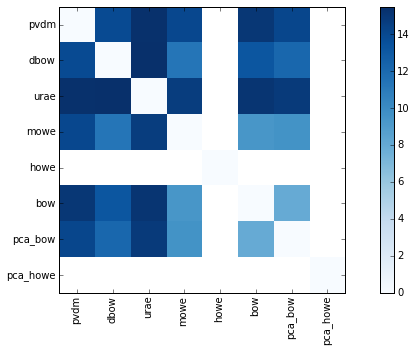

In [51]:
import matplotlib.cm as cm
def plot_matrix(cm, labels, cmap=cm.Blues):
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.colorbar()
    tick_marks = np.arange(len(labels))
    pl.xticks(tick_marks, labels, rotation=90)
    pl.yticks(tick_marks, labels)
    pl.tight_layout()
    
def get_interrater_e_distance(ratings):
    rating_dist = distance.pdist(n_group_sims.as_matrix().T)
    return distance.squareform(rating_dist)

def z_norm(col):
    return (col-col.mean())/col.std()

n_group_sims = group_sims.apply(z_norm)


interrater_e_distance = get_interrater_e_distance(n_group_sims)
print(pd.DataFrame( interrater_e_distance, columns =n_group_sims.columns, index=n_group_sims.columns))
      
plot_matrix(interrater_e_distance, n_group_sims.columns)

In [14]:
def get_centroid(group):
    xs = np.row_stack(group)
    return list(xs.mean(axis=0)) #Euclidean



def get_medoid(group):
    points=np.row_stack(group)
    ingroup_index = distance.cdist(points,points, 'cosine').sum(axis=1).argmin()
    return list(points[ingroup_index,:])


def get_angular_centroid(group):
    # the angular centroid is a line, here we choes an arbitairy point on it.
    # Dicussion of how normalising and adding wroks is at http://math.stackexchange.com/a/925659/1505
    points = np.row_stack(group)
    unit_points = points/np.linalg.norm(points,axis=1)[:,None]  #Normalise ot unit vectors
    return list(np.sum(unit_points,axis=0))
    

def get_group_medoids(series):
    return series.groupby(level=0).agg(get_medoid)


def get_group_centroids(series):
    return series.groupby(level=0).agg(get_centroid)


In [52]:

#Davies-Bouldin Index 
#Modified to use angular centroid, and angular distance

def davied_bouldin_index(series):

    def av_dist_to_centroid(group):
        xs = np.row_stack(group)
        c = get_angular_centroid(group)
        return distance.cdist(xs,[c], angular_dist).mean()

    group_centroids = get_group_centroids(series)
    group_spreads = series.groupby(level=0).agg(av_dist_to_centroid)
    
    n_groups = len(group_spreads)
    
    total = 0.0
    for ii in range(n_groups):
        greatest = -1*np.Inf
        for jj in range(n_groups):
            if ii==jj:
                continue

            numer = group_spreads.iloc[ii] + group_spreads.iloc[jj] 
            denom = angular_dist(group_centroids.iloc[ii],group_centroids.iloc[jj]) #Euclidean
            value = numer/denom
            greatest = max(greatest, value)
        total+= greatest
    return total/n_groups

            
for column in df.columns[1:]:
    print(column + " " + str(davied_bouldin_index(df.loc[:,column])))

pvdm 8.74738967341
dbow 3.19232483045
urae 3.32528587479
mowe 2.96614747269
howe 2.28540671027
bow 3.35340554402
pca_bow 3.81762874803
pca_howe 6.97912916249


In [53]:
def get_true_classes(series):
    return np.asarray([ii[0] for ii in series.index])

In [54]:
def get_classes_about_center(series, center_fun):
    group_centers = np.row_stack(series.groupby(level=0).agg(center_fun)) 
    points  = np.row_stack(series)
    class_indexes = distance.cdist(points,group_centers, 'cosine').argmin(axis=1)
    return np.asarray(series.index[class_indexes].labels[0])

def get_classes_by_similarity_to_true_classes(series):
    true_classes = get_true_classes(series)
    
    def av_dist_to_group(point, group):
        xs = np.row_stack(group)
        return distance.cdist(xs, [point]).mean()
    
    return np.asarray([series.groupby(level=0).agg(lambda group: av_dist_to_group(point, group)).idxmin()
               for point in series])
    



def recluster_success(series):
    true_classes = get_true_classes(series)

    def get_acc(center_fun):
        classes = get_classes_about_center(series, center_fun)
        return (classes == true_classes).sum()/len(true_classes)
    
    classes = get_classes_by_similarity_to_true_classes(series)
    group_closeness_acc = (classes == true_classes).sum()/len(true_classes)

    return pd.Series([get_acc(get_centroid),
                      get_acc(get_medoid),
                      get_acc(get_angular_centroid),
                      group_closeness_acc
                     ], index="centroid_acc medoid_acc angular_centroid_acc group_closeness_acc".split()) 
    

recluster_results = pd.DataFrame()
for column in df.columns[1:]:
    recluster_results[column] = recluster_success(df[column])

recluster_results

KeyboardInterrupt: 

In [ ]:
#Lets take a look at what mistakes are being made.
#We can look at the exemplary member of each class as a repressentitive,
#And can compare that for the class it was given to that for the class it should have been given

def get_exemplars(df, col_name, get_center_fun):
    series = df[col_name]
    def get_exemplar(group):
        c = get_center_fun(group)
        points=np.row_stack(group)
        ingroup_index = distance.cdist(points,[c], 'cosine').flatten().argmin()
        df_index = group.index[ingroup_index]
        return df.tokenized_phrases[df_index]
    
    return series.groupby(level=0).agg(get_exemplar)


def get_mistakes(df, col_name, get_center_fun=get_angular_centroid):
    group_exemplars = get_exemplars(df, col_name,get_center_fun)
    
    series = df[col_name]
    
    classes = get_classes(series, get_center_fun)
    
    return show_mistakes(df, classes, col_name, get_center_fun)


def show_mistakes(df, actual_classes, col_for_exemplar="bow", get_center_fun = get_angular_centroid):
    group_exemplars = get_exemplars(df, col_for_exemplar, get_center_fun)
    
    true_classes = get_true_classes(df)
    mistake_indexs = np.nonzero(actual_classes!=true_classes)
    
    ret = pd.DataFrame()
    ret["mistaken_texts"] = list(df.tokenized_phrases.iloc[mistake_indexs])
    ret["true_exemplar"] = list(group_exemplars[true_classes[mistake_indexs]])
    ret["actual_exemplar"] = list(group_exemplars[actual_classes[mistake_indexs]])
    
    return ret


In [28]:
#show_mistakes(df, get_classes_by_similarity_to_true_classes(df.bow))

In [29]:
#get_mistakes(df, "bow",get_angular_centroid)

In [56]:
from sklearn.svm import NuSVC, SVC, LinearSVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

#class_weight = {key: 1/value for (key, value) in Counter(training_data.debate_type).items()}

def classify(column, classifier, train_data, test_data, train_labels, test_labels):
    train_data_X = np.row_stack(train_data[column])
    test_data_X = np.row_stack(test_data[column])

    classifier.fit(train_data_X, train_labels)
    
    return classifier.score(test_data_X, test_labels)


classifiers = [LinearSVC(class_weight="auto",  max_iter=200), 
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=10),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=100),        
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=1000),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=10000),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=100000),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=1000000),
        #OneVsRestClassifier(SVC(class_weight="auto",  max_iter=20000, kernel='rbf')),
        #tree.DecisionTreeClassifier(class_weight="auto")
        
        
       ]
best_classify_results = pd.DataFrame(index=classifiers)
for column in df.columns[1:]:
    best_classify_results.loc[:,column] = [classify(column, classifier,
                                                   train_data=df,
                                                   test_data=df,
                                                   train_labels=get_true_classes(df),
                                                   test_labels=get_true_classes(df))
                                            for classifier in classifiers]
    
best_classify_results

,pvdm,dbow,urae,mowe,howe,bow,pca_bow,pca_howe
"LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=200,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.439462,0.962631,0.772795,0.973094,1,1,0.998505,0.989537


In [57]:
from sklearn import cross_validation
n_folds = df.tokenized_phrases.groupby(level=0).agg(len).min()
print(str(n_folds)+"-fold validation")
classify_results = pd.DataFrame(index=classifiers)
for column in df.columns[1:]:
    for classifier in classifiers:
        cv_res = cross_validation.cross_val_score(classifier, 
                                          X = np.row_stack(df[column]),
                                          y = get_true_classes(df),
                                          cv=df[column].groupby(level=0).agg(len).min(),
                                          n_jobs=-1
                                        
                                          )
        classify_results.loc[classifier,(column)] = cv_res.mean()
        #classify_results.loc[svm,(column+"_std")] = cv_res.std()

classify_results

2-fold validation


,pvdm,dbow,urae,mowe,howe,bow,pca_bow,pca_howe
"LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=200,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.078889,0.2189,0.094214,0.595622,0.539654,0.514871,0.477385,0.408237


In [32]:
def get_symetry_measure(group):
    xs = np.row_stack(group)
    dist=distance.pdist(xs, angular_dist)
    c=get_angular_centroid(xs)
    dist = distance.cdist(xs, [c],angular_dist)
    return dist.std()

df.groupby(level=0).agg(get_symetry_measure).describe()
    

,pvdm,dbow,urae,mowe,bow,pca_bow
count,1.630000e+02,1.630000e+02,1.630000e+02,1.630000e+02,163.000000,1.630000e+02
mean,4.453344e-02,1.398872e-02,2.567149e-02,1.050908e-02,0.015603,1.897898e-02
std,4.954798e-02,1.584221e-02,2.963655e-02,1.168567e-02,0.017219,2.139135e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,7.850462e-17,7.850462e-17,7.850462e-17,1.110223e-16,0.000000,7.850462e-17
50%,2.888509e-02,7.781124e-03,1.344446e-02,8.153367e-03,0.011777,1.259193e-02
75%,8.288435e-02,2.658961e-02,4.655015e-02,1.852435e-02,0.029575,3.357847e-02
max,1.847368e-01,5.375267e-02,1.215960e-01,4.490277e-02,0.060226,7.923656e-02
